In [1]:
import numpy as np 
import jax.numpy as jnp
from jax import grad, random
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

In [2]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/churchland.npy') 
print(X.shape)

(108, 218, 61)


In [3]:
def sample_index_pairs(N, num_pairs=100, seed=0):
    key = random.PRNGKey(seed)
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))
    return index_pairs

def loss(U, X):                                                #U (N,d); X(K,N,T)
    K, N, T = X.shape

    U_tilde, _ = jnp.linalg.qr(U)

    index_pairs = sample_index_pairs(N)
    S = 0
    for i in index_pairs:
        id_1 = int(i[0])
        id_2 = int(i[1])

        Y = jnp.einsum('i,kl->kil', U_tilde[id_1,:], X[:,id_1,:])                 #(K,d,T)
        Y_prime = jnp.einsum('i,kl->kil', U_tilde[id_2,:], X[:,id_2,:])    

        YY = jnp.einsum('kdt,klt->kdl', Y, Y_prime)                               #(K,d,d)

        S += jnp.trace(YY, axis1=1, axis2=2)**2 - jnp.trace(YY * YY, axis1=1, axis2=2) 
    S = jnp.mean( 2/(K**2) * S )
    return - S

grad_loss = grad(loss)

def init_adam_optimizer(U_initial, learning_rate=0.001):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(U_initial)
    return optimizer, opt_state

def update_U(U, X, optimizer, opt_state):
    dL_dU = grad_loss(U, X)
    updates, opt_state_updated = optimizer.update(dL_dU, opt_state, U)
    U_updated = optax.apply_updates(U, updates)
    return U_updated, opt_state_updated

def optimize_U(X, iterations=100, learning_rate=0.001, d=3):
    K, N, T = X.shape
    key = random.PRNGKey(0)
    U = random.normal(key, (N, d))

    optimizer, opt_state = init_adam_optimizer(U, learning_rate)

    for i in range(iterations):
        U, opt_state = update_U(U, X, optimizer, opt_state)
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss(U, X)}")
    
    return U

optimized_U = optimize_U(X)                     #optimized_U (N,d)

Iteration 0, S: -2.7960996627807617
Iteration 10, S: 5.764190673828125
Iteration 20, S: 14.827240943908691
Iteration 30, S: 24.59210968017578
Iteration 40, S: 35.319671630859375
Iteration 50, S: 47.317325592041016
Iteration 60, S: 60.92952346801758
Iteration 70, S: 76.5623550415039
Iteration 80, S: 94.70336151123047
Iteration 90, S: 115.93855285644531


In [ ]:
#np.save('optimized_U_test_0', optimized_U)

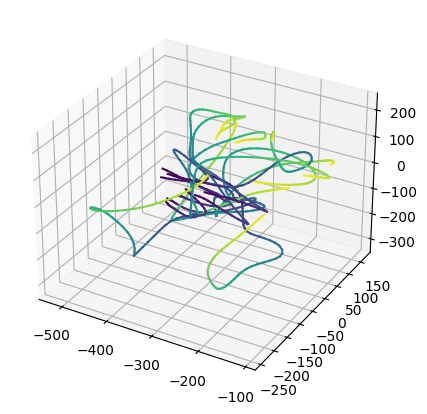

In [4]:
Y = jnp.einsum('ji,kjl->kil', optimized_U, X)   


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('viridis')

num_time_points = Y.shape[-1]
indices_to_plot = np.arange(0,Y.shape[0],10)  #[1,2,3,4,-1,-2,-3,-4]

for i in indices_to_plot:
    x = Y[i, 0, :]  
    y = Y[i, 1, :] 
    z = Y[i, 2, :]  
    
    for t in range(num_time_points - 1):
        ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))
